# Plan:
- Our probe labels a given dataset and tells us the estimated success rate (hardest-easiest)
- If it has a high success rate, this tells us that we will likely pass this problem (definitely will with more turns)
- If we have a low success rate, we should get a better model to look at our work, or increase the number of turns with the small model, or change to a better model.


In [1]:
import pandas as pd
import numpy as np
import os
import uuid
import base64
from vllm import LLM, SamplingParams
from math_verify import parse, verify
from tqdm import tqdm
from transformers import AutoTokenizer
from utils import evaluate_responses, verify_answer, parse_answers
from collections import Counter
from scipy.stats import spearmanr
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")

/opt/anaconda/envs/diff-direction/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 12-10 01:51:08 [__init__.py:241] Automatically detected platform cuda.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
GENERATION_SETTING_STR= "max_3000_k_1_temp_0"

In [4]:
MODEL_NAME = "Qwen/Qwen2.5-Math-1.5B-Instruct"
MODEL_ALIAS = MODEL_NAME.split("/")[-1]

In [5]:
DATASET_NAME = "AIME_1983_2024"
DATASET_NAME = "AIME_2025"
DATASET_NAME = "E2H-GSM8K"

In [6]:
LABELLED_DATA_PATH = f"/VData/linna4335/llms_know_difficult/runs/{MODEL_ALIAS}/datasplits/{DATASET_NAME}_predicted_by_predicting_learnability.json"

In [7]:
df = pd.read_json(LABELLED_DATA_PATH)

In [8]:
MATH_PROMPT_FORMATTING = " Please put your final answer inside \\boxed{}."
df["formatted_prompt"] = df["question"].apply(lambda x: x + MATH_PROMPT_FORMATTING)
df["id"] = [str(uuid.uuid1()) for uid in range(len(df))]
df["b64id"] = df["question"].apply(lambda x: base64.b64encode(x.encode()))

In [9]:
df["predicted_difficulty"].describe()

count    1319.000000
mean       -1.415236
std         3.554193
min       -14.924369
25%        -3.804402
50%        -1.308610
75%         1.174896
max         8.131352
Name: predicted_difficulty, dtype: float64

In [10]:
df["predicted_difficulty_sigmoid"].describe()

count    1.319000e+03
mean     3.737543e-01
std      3.722902e-01
min      3.299353e-07
25%      2.178743e-02
50%      2.127195e-01
75%      7.640285e-01
max      9.997059e-01
Name: predicted_difficulty_sigmoid, dtype: float64

In [11]:
llm = LLM(model=MODEL_NAME, gpu_memory_utilization=0.6)

INFO 12-10 01:51:11 [utils.py:326] non-default args: {'model': 'Qwen/Qwen2.5-Math-1.5B-Instruct', 'gpu_memory_utilization': 0.6, 'disable_log_stats': True}


INFO 12-10 01:51:20 [__init__.py:711] Resolved architecture: Qwen2ForCausalLM


`torch_dtype` is deprecated! Use `dtype` instead!


INFO 12-10 01:51:20 [__init__.py:1750] Using max model len 4096


2025-12-10 01:51:21,267	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 12-10 01:51:21 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=16384.
(EngineCore_0 pid=3723766) INFO 12-10 01:51:22 [core.py:636] Waiting for init message from front-end.
(EngineCore_0 pid=3723766) INFO 12-10 01:51:22 [core.py:74] Initializing a V1 LLM engine (v0.10.1.1) with config: model='Qwen/Qwen2.5-Math-1.5B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2.5-Math-1.5B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, decoding_config=DecodingConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_backend=''), observability_config=Observabi

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.34it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.33it/s]
(EngineCore_0 pid=3723766) 


(EngineCore_0 pid=3723766) INFO 12-10 01:51:26 [default_loader.py:262] Loading weights took 0.53 seconds
(EngineCore_0 pid=3723766) INFO 12-10 01:51:27 [gpu_model_runner.py:2007] Model loading took 2.8798 GiB and 1.184995 seconds
(EngineCore_0 pid=3723766) INFO 12-10 01:51:33 [backends.py:548] Using cache directory: /home/lina4335/.cache/vllm/torch_compile_cache/63465de3ab/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_0 pid=3723766) INFO 12-10 01:51:33 [backends.py:559] Dynamo bytecode transform time: 5.82 s
(EngineCore_0 pid=3723766) INFO 12-10 01:51:37 [backends.py:161] Directly load the compiled graph(s) for dynamic shape from the cache, took 3.736 s
(EngineCore_0 pid=3723766) INFO 12-10 01:51:38 [monitor.py:34] torch.compile takes 5.82 s in total
(EngineCore_0 pid=3723766) INFO 12-10 01:51:38 [gpu_worker.py:276] Available KV cache memory: 38.98 GiB
(EngineCore_0 pid=3723766) INFO 12-10 01:51:39 [kv_cache_utils.py:849] GPU KV cache size: 1,459,856 tokens
(EngineCore_0 pid=3

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 67/67 [00:01<00:00, 46.81it/s]


(EngineCore_0 pid=3723766) INFO 12-10 01:51:40 [gpu_model_runner.py:2708] Graph capturing finished in 2 secs, took 0.58 GiB
(EngineCore_0 pid=3723766) INFO 12-10 01:51:40 [core.py:214] init engine (profile, create kv cache, warmup model) took 13.51 seconds
INFO 12-10 01:51:41 [llm.py:298] Supported_tasks: ['generate']


In [43]:
PROMPTS = df["formatted_prompt"].to_list()
GTS = df["answer"].to_list()
PREDICTED_DIFFICULTIES = df["predicted_difficulty"].to_list()
PREDICTED_DIFFICULTIES_SIGMOID = df["predicted_difficulty_sigmoid"].to_list()

In [44]:
PROMPTS[0]

'$18 is shared among 3 boys. The eldest added $5 to his share and added another $10 the following day. He later needed some money and spent $8 from his total so far. After saving some more, he was able to triple the amount he had left after spending the $8. How much does he have now? Please put your final answer inside \\boxed{}.'

### Baseline Performance

In [14]:
PARAMS = SamplingParams(temperature=0.0, max_tokens=3000)

In [15]:
outputs = llm.generate(PROMPTS, PARAMS)
RESP = []
TOKEN_LENGTHS = []
for output in outputs:
    prompt = output.prompt
    generated_text = output.outputs[0].text
    token_length = len(output.outputs[0].token_ids)
    RESP.append(generated_text)
    TOKEN_LENGTHS.append(token_length)

Processed prompts: 100%|██████████| 1319/1319 [00:20<00:00, 65.23it/s, est. speed input: 4586.23 toks/s, output: 23057.80 toks/s] 


In [16]:
is_correct, accuracy, num_correct, total = evaluate_responses(RESP, GTS)
print(f"Baseline Accuracy: {accuracy:.2f}% ({num_correct}/{total})")

Baseline Accuracy: 84.69% (1117/1319)


In [17]:
baseline_df = df.copy()
baseline_df["is_correct"] = is_correct
baseline_df["response"] = RESP
baseline_df["token_length"] = TOKEN_LENGTHS
# For baseline, all stats are the same since it's a single generation
baseline_df["token_length_min"] = TOKEN_LENGTHS
baseline_df["token_length_max"] = TOKEN_LENGTHS
baseline_df["token_length_median"] = TOKEN_LENGTHS
baseline_df["token_length_mean"] = TOKEN_LENGTHS

In [18]:
MAJORITY_VOTE_RESULTS_DIR = f"../predicting_learnability/MAJORITY_VOTE_DATA/{DATASET_NAME}"
os.makedirs(MAJORITY_VOTE_RESULTS_DIR, exist_ok=True)

In [19]:
# baseline_df.to_parquet(f"{MAJORITY_VOTE_RESULTS_DIR}/{MODEL_ALIAS}_baseline_df_{GENERATION_SETTING_STR}.parquet")

In [20]:
baseline_df["predicted_difficulty_sigmoid"].describe()

count    1.319000e+03
mean     3.737543e-01
std      3.722902e-01
min      3.299353e-07
25%      2.178743e-02
50%      2.127195e-01
75%      7.640285e-01
max      9.997059e-01
Name: predicted_difficulty_sigmoid, dtype: float64

In [21]:
baseline_df["binary_predicted_success_rate"] = baseline_df["predicted_difficulty_sigmoid"].apply(lambda x: 1 if x >= baseline_df["predicted_difficulty_sigmoid"].mean() else 0)

In [22]:
MATH_DF_PATH = "../predicting_learnability/data/MATH_{MODEL_ALIAS}-SR_{split}.parquet"

In [23]:
math_train_df = pd.read_parquet(MATH_DF_PATH.format(MODEL_ALIAS=MODEL_ALIAS, split="train"))
math_test_df = pd.read_parquet(MATH_DF_PATH.format(MODEL_ALIAS=MODEL_ALIAS, split="test"))

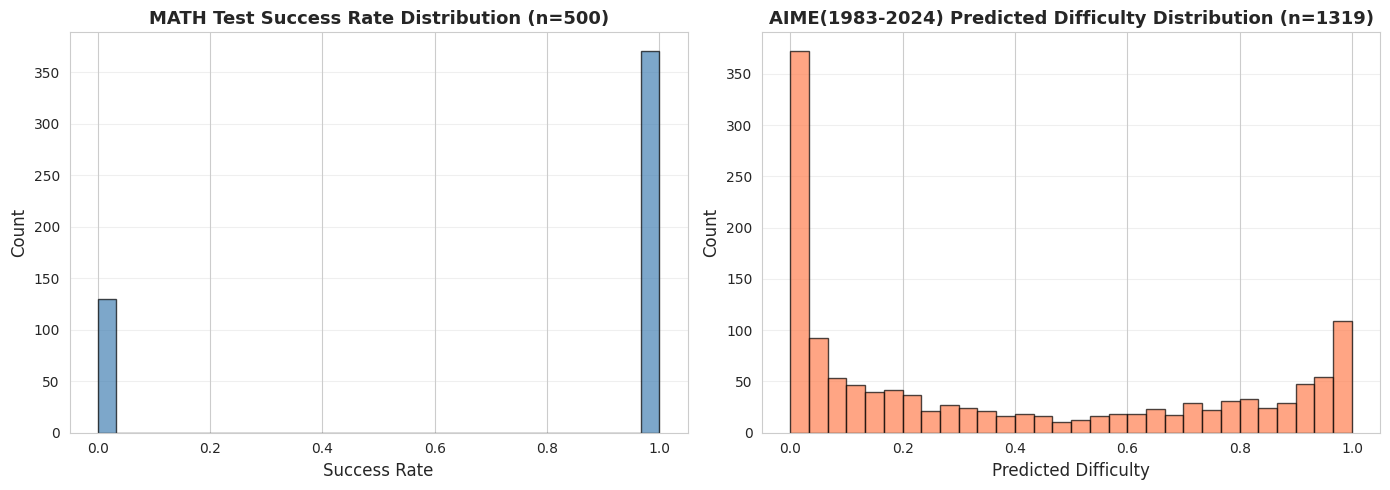

MATH Test Success Rate - Mean: 0.7400, Median: 1.0000
AIME Predicted Difficulty - Mean: 0.3738, Median: 0.2127


In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: MATH test success rate
ax1 = axes[0]
math_test_df["success_rate"].hist(bins=30, ax=ax1, color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Success Rate', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title(f'MATH Test Success Rate Distribution (n={len(math_test_df)})', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)


# Plot 2: AIME baseline predicted difficulty
ax2 = axes[1]
baseline_df["predicted_difficulty_sigmoid"].hist(bins=30, ax=ax2, color='coral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Predicted Difficulty', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title(f'AIME(1983-2024) Predicted Difficulty Distribution (n={len(baseline_df)})', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"MATH Test Success Rate - Mean: {math_test_df['success_rate'].mean():.4f}, Median: {math_test_df['success_rate'].median():.4f}")
print(f"AIME Predicted Difficulty - Mean: {baseline_df['predicted_difficulty_sigmoid'].mean():.4f}, Median: {baseline_df['predicted_difficulty_sigmoid'].median():.4f}")

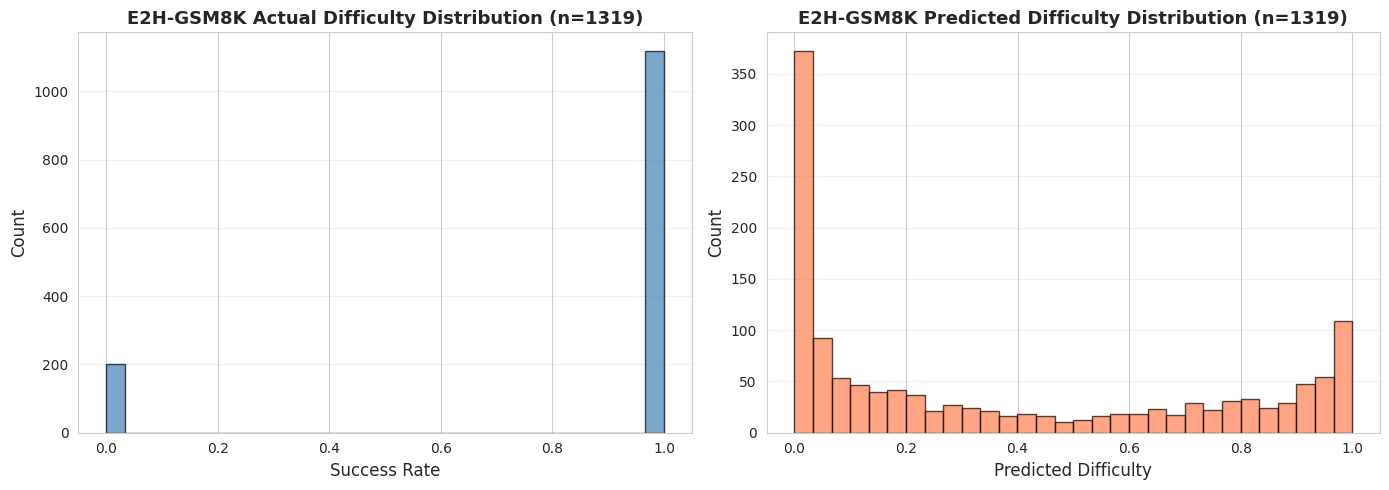

AIME Actual Success Rate - Mean: 0.8469, Median: 1.0000
AIME Predicted Difficulty - Mean: 0.3738, Median: 0.2127


In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: MATH test success rate
ax1 = axes[0]
baseline_df["is_correct"].hist(bins=30, ax=ax1, color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Success Rate', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title(f'{DATASET_NAME} Actual Difficulty Distribution (n={len(baseline_df)})', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)


# Plot 2: AIME baseline predicted difficulty
ax2 = axes[1]
baseline_df["predicted_difficulty_sigmoid"].hist(bins=30, ax=ax2, color='coral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Predicted Difficulty', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title(f'{DATASET_NAME} Predicted Difficulty Distribution (n={len(baseline_df)})', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"AIME Actual Success Rate - Mean: {baseline_df['is_correct'].mean():.4f}, Median: {baseline_df['is_correct'].median():.4f}")
print(f"AIME Predicted Difficulty - Mean: {baseline_df['predicted_difficulty_sigmoid'].mean():.4f}, Median: {baseline_df['predicted_difficulty_sigmoid'].median():.4f}")

In [26]:
BASELINE_SR = baseline_df["is_correct"].tolist()
RAW_SR = baseline_df["predicted_difficulty"].tolist()
PREDICTING_COL = "predicted_difficulty_sigmoid"

In [65]:
# THRESHOLD = baseline_df[PREDICTING_COL].mean()
THRESHOLD = 0.5

In [66]:
THRESHOLD

0.5

In [67]:
def threshold_func(predicted, threshold):
    if predicted >= threshold:
        return 1
    else:
        return 0

In [68]:
baseline_df["binary_predicted_success_rate"] = baseline_df[PREDICTING_COL].apply(lambda x: threshold_func(x, THRESHOLD))

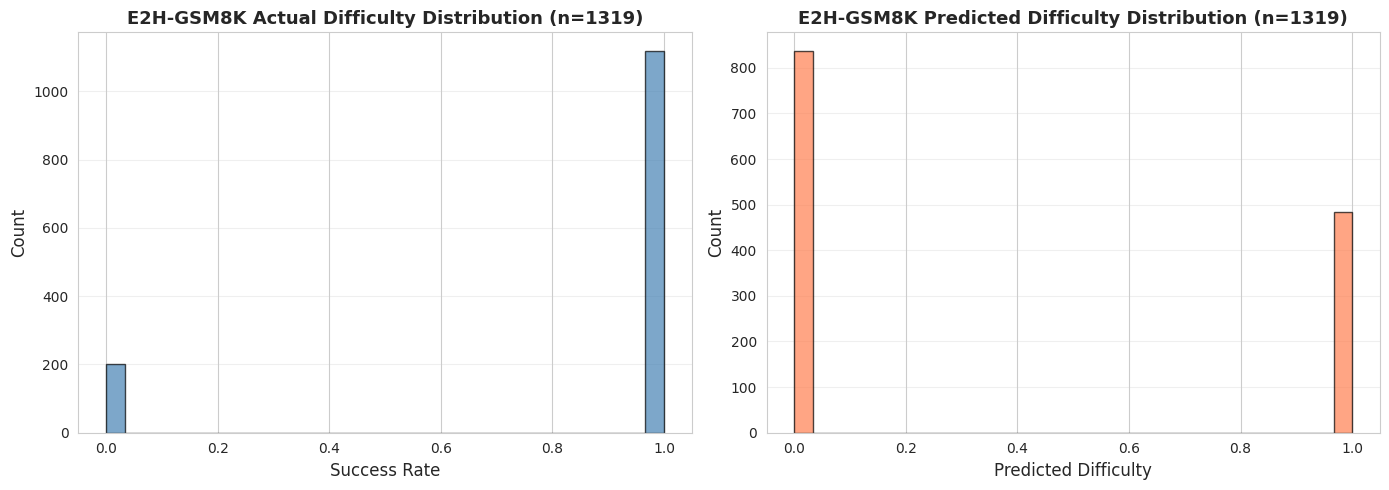

E2H-GSM8K Actual Success Rate - Mean: 0.8469, Median: 1.0000
E2H-GSM8K Predicted Difficulty - Mean: 0.3662, Median: 0.0000


In [69]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: MATH test success rate
ax1 = axes[0]
baseline_df["is_correct"].hist(bins=30, ax=ax1, color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Success Rate', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title(f'{DATASET_NAME} Actual Difficulty Distribution (n={len(baseline_df)})', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)


# Plot 2: AIME baseline predicted difficulty
ax2 = axes[1]
baseline_df["binary_predicted_success_rate"].hist(bins=30, ax=ax2, color='coral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Predicted Difficulty', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title(f'{DATASET_NAME} Predicted Difficulty Distribution (n={len(baseline_df)})', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"{DATASET_NAME} Actual Success Rate - Mean: {baseline_df['is_correct'].mean():.4f}, Median: {baseline_df['is_correct'].median():.4f}")
print(f"{DATASET_NAME} Predicted Difficulty - Mean: {baseline_df['binary_predicted_success_rate'].mean():.4f}, Median: {baseline_df['binary_predicted_success_rate'].median():.4f}")

In [70]:
accuracy_score(baseline_df["is_correct"].tolist(), baseline_df["binary_predicted_success_rate"].tolist())

0.44806671721000757

In [71]:
print(classification_report(baseline_df["is_correct"].tolist(), baseline_df["binary_predicted_success_rate"].tolist()))

              precision    recall  f1-score   support

           0       0.19      0.77      0.30       202
           1       0.90      0.39      0.55      1117

    accuracy                           0.45      1319
   macro avg       0.54      0.58      0.42      1319
weighted avg       0.79      0.45      0.51      1319



In [72]:
print(classification_report(baseline_df["is_correct"].tolist(), baseline_df["binary_predicted_success_rate"].tolist()))

              precision    recall  f1-score   support

           0       0.19      0.77      0.30       202
           1       0.90      0.39      0.55      1117

    accuracy                           0.45      1319
   macro avg       0.54      0.58      0.42      1319
weighted avg       0.79      0.45      0.51      1319



In [73]:
BASELINE_SR = baseline_df["is_correct"].tolist()
RAW_SR = baseline_df["predicted_difficulty"].tolist()
BINARY_PREDICTED_SR = baseline_df["binary_predicted_success_rate"].tolist()

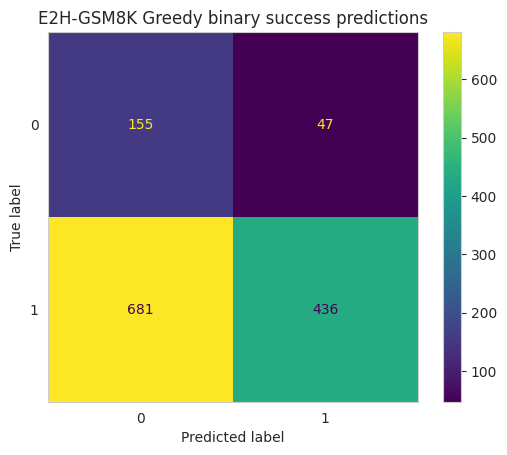

In [74]:
cm = confusion_matrix(BASELINE_SR, BINARY_PREDICTED_SR, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()
plt.title(f"{DATASET_NAME} Greedy binary success predictions")
plt.grid(False)
plt.show()

In [75]:
roc_auc_score(BASELINE_SR, RAW_SR)

0.6300424581401739

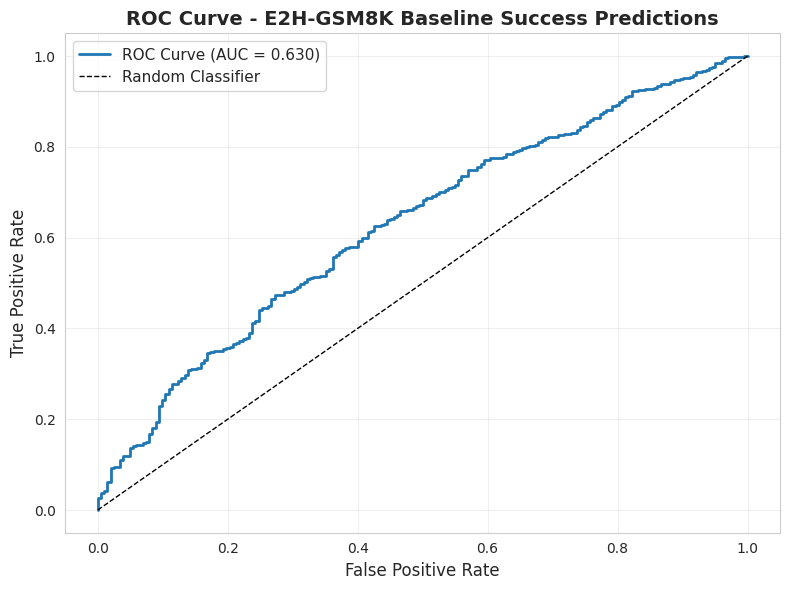

In [37]:
fpr, tpr, thresholds = roc_curve(BASELINE_SR, RAW_SR)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc_score(BASELINE_SR, RAW_SR):.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve - {DATASET_NAME} Baseline Success Predictions', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'{MAJORITY_VOTE_RESULTS_DIR}/{MODEL_ALIAS}_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [96]:
PREDICTING_COL = "predicted_difficulty"  # instead of the sigmoid column

In [97]:
quantiles = [0.1, 0.2, 0.3, 0.4]

for q in quantiles:
    threshold = baseline_df[PREDICTING_COL].quantile(q)

    # low score = "hard" = we want to send these to SC
    baseline_df["binary_predicted_success_rate"] = (
        baseline_df[PREDICTING_COL] >= threshold
    ).astype(int)
    # => score < threshold → 0 → "hard" (SC region)
    #    score >= threshold → 1 → "easy" (stay greedy)

    # Now compute metrics for this threshold:
    BASELINE_SR = baseline_df["is_correct"].tolist()
    BINARY_PREDICTED_SR = baseline_df["binary_predicted_success_rate"].tolist()

    # confusion matrix / classification report
    print(f"\n=== Quantile {q:.1f} (threshold={threshold:.4f}) ===")
    print(confusion_matrix(BASELINE_SR, BINARY_PREDICTED_SR, labels=[0,1]))
    print(classification_report(BASELINE_SR, BINARY_PREDICTED_SR))

    # subset to send to SC (predicted 0)
    MAJORITY_VOTE_DF = baseline_df[baseline_df["binary_predicted_success_rate"] == 0].copy()
    print(f"Fraction routed to SC: {len(MAJORITY_VOTE_DF) / len(baseline_df):.3f}")
    
    # here you can plug in your existing self-consistency eval:
    #  - run SC-k on MAJORITY_VOTE_DF
    #  - compute is_correct_delta distribution
    #  - compute router accuracy & average #samples



=== Quantile 0.1 (threshold=-6.0037) ===
[[  36  166]
 [  96 1021]]
              precision    recall  f1-score   support

           0       0.27      0.18      0.22       202
           1       0.86      0.91      0.89      1117

    accuracy                           0.80      1319
   macro avg       0.57      0.55      0.55      1319
weighted avg       0.77      0.80      0.78      1319

Fraction routed to SC: 0.100

=== Quantile 0.2 (threshold=-4.4297) ===
[[ 62 140]
 [202 915]]
              precision    recall  f1-score   support

           0       0.23      0.31      0.27       202
           1       0.87      0.82      0.84      1117

    accuracy                           0.74      1319
   macro avg       0.55      0.56      0.55      1319
weighted avg       0.77      0.74      0.75      1319

Fraction routed to SC: 0.200

=== Quantile 0.3 (threshold=-3.1207) ===
[[ 90 112]
 [306 811]]
              precision    recall  f1-score   support

           0       0.23      0.45 

## do majotity voting for questions predicted to be 0

In [50]:
baseline_df["binary_predicted_success_rate"].value_counts()

binary_predicted_success_rate
0    836
1    483
Name: count, dtype: int64

In [ ]:
baseline_df[baseline_df["binary_predicted_success_rate"] == 0]

In [83]:
MAJORITY_VOTE_DF = baseline_df.copy()
# MAJORITY_VOTE_DF = baseline_df[baseline_df["binary_predicted_success_rate"] == 0].copy()

In [76]:
NUM_SAMPLES = 5
PARAMS = SamplingParams(temperature=0.6, max_tokens=3000)

In [ ]:
MAJORITY_VOTE_DF

In [ ]:
PROMPT_RESPONSE_STORE = dict()
PROMPT_PARSED_ANSWER_STORE = dict()
PROMPT_TOKEN_LENGTHS_STORE = dict()
MAJORITY_VOTE_CORRECT_STORE = []
MAJORITY_VOTE_ANSWER_STORE = []
TOKEN_LENGTH_MIN_STORE = []
TOKEN_LENGTH_MAX_STORE = []
TOKEN_LENGTH_MEDIAN_STORE = []
TOKEN_LENGTH_MEAN_STORE = []

# for each prompt, generate responses, extract answers,
# choose most common answer and verify correctness
for idx, SINGLE_PROMPT in enumerate(PROMPTS):
    REPEATED_SINGLE_PROMPTS = [SINGLE_PROMPT] * NUM_SAMPLES
    REPEATED_SINGLE_GTS = [GTS[idx]] * NUM_SAMPLES
    outputs = llm.generate(REPEATED_SINGLE_PROMPTS, PARAMS)
    SINGLE_PROMPT_RESPONSES = []
    SINGLE_PROMPT_TOKEN_LENGTHS = []
    
    for output in outputs:
        prompt = output.prompt
        generated_text = output.outputs[0].text
        token_length = len(output.outputs[0].token_ids)
        SINGLE_PROMPT_RESPONSES.append(generated_text)
        SINGLE_PROMPT_TOKEN_LENGTHS.append(token_length)
    
    # store all the responses per question
    PROMPT_RESPONSE_STORE[idx] = SINGLE_PROMPT_RESPONSES
    PROMPT_TOKEN_LENGTHS_STORE[idx] = SINGLE_PROMPT_TOKEN_LENGTHS
    
    # Calculate token length statistics
    TOKEN_LENGTH_MIN_STORE.append(min(SINGLE_PROMPT_TOKEN_LENGTHS))
    TOKEN_LENGTH_MAX_STORE.append(max(SINGLE_PROMPT_TOKEN_LENGTHS))
    TOKEN_LENGTH_MEDIAN_STORE.append(np.median(SINGLE_PROMPT_TOKEN_LENGTHS))
    TOKEN_LENGTH_MEAN_STORE.append(np.mean(SINGLE_PROMPT_TOKEN_LENGTHS))

    SINGLE_PARSED_ANSWER_LIST = parse_answers(SINGLE_PROMPT_RESPONSES)
    PROMPT_PARSED_ANSWER_STORE[idx] = SINGLE_PARSED_ANSWER_LIST
    try:
        SINGLE_PARSED_ANSWER_LIST_OPTION1 = [temp_ans[0] for temp_ans in SINGLE_PARSED_ANSWER_LIST]
    except Exception:
        print("couldn't parse answer, returning empty string")
        SINGLE_PARSED_ANSWER_LIST_OPTION1 = [""]
    try:
        SINGLE_PARSED_ANSWER_LIST_OPTION2 = [temp_ans[1] for temp_ans in SINGLE_PARSED_ANSWER_LIST]
    except Exception:
        print("couldn't parse answer, returning empty string")
        SINGLE_PARSED_ANSWER_LIST_OPTION2 = [""]

    FINAL_SINLE_PARSED_ANSWER_LIST = SINGLE_PARSED_ANSWER_LIST_OPTION1 + SINGLE_PARSED_ANSWER_LIST_OPTION2

    MAJORITY_VOTE_ANSWER =  Counter(FINAL_SINLE_PARSED_ANSWER_LIST).most_common(1)[0][0]

    IS_CORRECT = verify(parse(f"${REPEATED_SINGLE_GTS[0]}$"), MAJORITY_VOTE_ANSWER)
    MAJORITY_VOTE_CORRECT_STORE.append(IS_CORRECT)
    MAJORITY_VOTE_ANSWER_STORE.append(MAJORITY_VOTE_ANSWER)

In [84]:
MAJORITY_VOTE_DF["is_correct"] = MAJORITY_VOTE_CORRECT_STORE
MAJORITY_VOTE_DF["majority_answer"] = MAJORITY_VOTE_ANSWER_STORE
MAJORITY_VOTE_DF["token_length_min"] = TOKEN_LENGTH_MIN_STORE
MAJORITY_VOTE_DF["token_length_max"] = TOKEN_LENGTH_MAX_STORE
MAJORITY_VOTE_DF["token_length_median"] = TOKEN_LENGTH_MEDIAN_STORE
MAJORITY_VOTE_DF["token_length_mean"] = TOKEN_LENGTH_MEAN_STORE

print(f"\nMajority Vote Accuracy: {MAJORITY_VOTE_DF["is_correct"].mean() * 100:.2f}%, ({MAJORITY_VOTE_DF["is_correct"].sum()}/{len(MAJORITY_VOTE_DF)})\n")


Majority Vote Accuracy: 86.73%, (1144/1319)



In [85]:
MAJORITY_VOTE_DF_PRED_0 = MAJORITY_VOTE_DF[baseline_df["binary_predicted_success_rate"] == 0].copy()

In [91]:
MAJORITY_VOTE_DF_PRED_0["is_correct_delta"] = MAJORITY_VOTE_DF_PRED_0["is_correct"] - baseline_df["is_correct"]
MAJORITY_VOTE_DF["is_correct_delta"] = MAJORITY_VOTE_DF["is_correct"] - baseline_df["is_correct"]

In [95]:
print("is_correct_delta is calculated by majority_vote_is_correct - baseline_is_correct")
print("k=5 improvement in subset where we predicted 0 success rate")
MAJORITY_VOTE_DF_PRED_0["is_correct_delta"].value_counts()

is_correct_delta is calculated by majority_vote_is_correct - baseline_is_correct
k=5 improvement in subset where we predicted 0 success rate


is_correct_delta
0     752
1      54
-1     30
Name: count, dtype: int64

In [93]:
print("k=5 improvement in full dataset")
MAJORITY_VOTE_DF["is_correct_delta"].value_counts()

k=5 improvement in full dataset


is_correct_delta
 0    1214
 1      66
-1      39
Name: count, dtype: int64

In [78]:
SINGLE_PARSED_ANSWER_LIST

[[1875, '1875'], [1875, '1875'], [1875, '1875'], [1875, '1875'], []]

### difficulty probes are plug-and-play signals for dynamic compute, both within a model (SC) and across models.

### SC Config

In [ ]:
from dataclasses import dataclass
from typing import Literal, Optional, Callable
from enum import Enum

class DifficultyLevel(Enum):
    EASY = "easy"
    MEDIUM = "medium"
    HARD = "hard"
    VERY_HARD = "very_hard"

class SolverStrategy(Enum):
    DIRECT = "direct" #sovle the problem directly
    SELF_CONSISTENCY_SAME = "self_consistency_same" #get the same llm to generate multiple answers
    SELF_CONSISTENCY_STRONG_MODEL = "self_consistency_strong_model" #get a better llm to generate MA's
    SELF_VERIFY_SAME = "self_verify_same" # ask the same llm to reflect on the generated answer.
    SELF_VERIFY_STRONG_MODEL = "self_verify_strong_model" #ask a stronger llm to reflect on the genrated answer

@dataclass
class SolverConfig:
    """Configuration for a solver strategy"""
    strategy: SolverStrategy
    model_name: str
    temperature: float
    num_samples: int = 1
    use_verification: bool = False
    
@dataclass
class Question:
    """Question with metadata"""
    text: str
    ground_truth: str
    difficulty_score: float
    index: int
    
@dataclass
class SolverResult:
    """Result from solving a question"""
    question_idx: int
    strategy_used: SolverStrategy
    response: str
    is_correct: int
    difficulty_level: DifficultyLevel
    num_attempts: int = 1

In [ ]:
class DifficultyRouter:
    """Routes questions to appropriate solving strategies based on difficulty.
    
    Note: difficulty_score is a SUCCESS RATE prediction (0-1):
    - Higher values (e.g., 0.8) = EASIER questions (high predicted success)
    - Lower values (e.g., 0.2) = HARDER questions (low predicted success)
    """
    
    def __init__(self, very_hard_threshold=0.15, hard_threshold=0.4, medium_threshold=0.7):
        """
        Args:
            very_hard_threshold: Below this success rate = very hard (use strong model)
            hard_threshold: Below this success rate = hard (use multi-sample)
            medium_threshold: Below this success rate = medium (use CoT)
            Above medium_threshold = easy (direct solve)
        """
        self.very_hard_threshold = very_hard_threshold
        self.hard_threshold = hard_threshold
        self.medium_threshold = medium_threshold
        
    def classify_difficulty(self, difficulty_score: float) -> DifficultyLevel:
        """Classify question difficulty based on predicted success rate.
        
        Lower success rate = harder question
        """
        if difficulty_score < self.very_hard_threshold:
            return DifficultyLevel.VERY_HARD
        elif difficulty_score < self.hard_threshold:
            return DifficultyLevel.HARD
        elif difficulty_score < self.medium_threshold:
            return DifficultyLevel.MEDIUM
        else:
            return DifficultyLevel.EASY
    
    def route(self, question: Question) -> SolverConfig:
        """Route question to appropriate solver based on difficulty"""
        difficulty = self.classify_difficulty(question.difficulty_score)
        
        if difficulty == DifficultyLevel.EASY:
            # Easy questions (high success rate): direct solve with weak model
            return SolverConfig(
                strategy=SolverStrategy.DIRECT,
                model_name="weak",
                temperature=0.0,
                num_samples=1,
                use_verification=False
            )
        elif difficulty == DifficultyLevel.MEDIUM:
            # Medium questions (moderate success rate): CoT with weak model
            return SolverConfig(
                strategy=SolverStrategy.SELF_CONSISTENCY_SAME,
                model_name="weak",
                temperature=0.0,
                num_samples=1,
                use_verification=False
            )
        elif difficulty == DifficultyLevel.HARD:
            # Hard questions (low success rate): Multi-sample with verification
            return SolverConfig(
                strategy=SolverStrategy.SELF_CONSISTENCY_STRONG_MODEL,
                model_name="weak",
                temperature=0.7,
                num_samples=5,
                use_verification=True
            )
        else:  # VERY_HARD
            # Very hard (very low success rate): Use strong model with verification
            return SolverConfig(
                strategy=SolverStrategy.STRONG_MODEL,
                model_name="strong",
                temperature=0.0,
                num_samples=1,
                use_verification=True
            )

# Initialize router with corrected thresholds (lower = harder)
router = DifficultyRouter(very_hard_threshold=0.15, hard_threshold=0.4, medium_threshold=0.7)
print("Difficulty Router initialized with SUCCESS RATE thresholds:")
print(f"  Very Hard: success rate < {0.15}")
print(f"  Hard: success rate < {0.4}")
print(f"  Medium: success rate < {0.7}")
print(f"  Easy: success rate >= {0.7}")

## Other dataset to investigate for OOD

In [ ]:
# Learning How Hard to Think: Input-Adaptive Allocation of LM Computation
### their probe used: 15K training samples, 2K validation samples and 3K test samples from AI-MO/NuminaMath-CoT

In [38]:
from datasets import load_dataset

In [39]:
ds = load_dataset("AI-MO/NuminaMath-CoT")

In [47]:
ds_filtered = ds["train"].filter(lambda x: x["source"].lower() != "math")

Filter: 100%|██████████| 859494/859494 [00:09<00:00, 90446.64 examples/s]


In [48]:
ds["train"]

Dataset({
    features: ['source', 'problem', 'solution', 'messages'],
    num_rows: 859494
})

In [42]:
ds_filtered

Dataset({
    features: ['source', 'problem', 'solution', 'messages'],
    num_rows: 99
})